<a href="https://colab.research.google.com/github/ekaterinatao/datatone_Pawfull/blob/master/Team_Pawfull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import glob
import re
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

import warnings
warnings.simplefilter("ignore")

# Functions

In [2]:
def col_year(col: pd.Series) -> pd.Series:
    """
    The function gets year from string (file name).

    :param col: row feature
    :return: modified feature
    """
    col = re.findall(r'[0-9]+', col)[0]

    return col

In [3]:
def histogramming(numerical_features: list, 
                  string: int, 
                  col: int,
                  df: pd.DataFrame, 
                  figsize: tuple, 
                  bins: int=25) -> None:
    '''
    The function prints the histogram of feature.

    :param numerical_features: list of numerical features
    :param string: count of strings in subplots
    :col: count of columns in subplots
    :param df: dataframe
    :param figsize: tuple of sizes of the figure
    :bins(optional): count of bins
    :return: None 
    '''
    fig, axs = plt.subplots(string, col, figsize=figsize)
    axs = axs.flatten()
    for i, col_name in enumerate(numerical_features):
        sns.histplot(
            data=df,
            x=col_name,
            bins=bins,
            kde=False,
            color='green',
            ax=axs[i]
        );

        axs[i].set_xlabel(f'Level of {col_name}')
        axs[i].set_ylabel('Number of countries')
        axs[i].set_title(
            f'Distribution of {col_name}', 
            fontsize=12, weight='bold'
        )

In [4]:
def shapiro_wilk(feature: str, 
                 df: pd.DataFrame) -> None:
    '''
    The function prints the p-value for the Shapiro-Wilk test.

    :param feature: name of feature
    :param df: dataframe
    :return: None 
    '''
    feat = df[df[feature].notnull()][feature]
    stat, p = stats.shapiro(feat)
    print(f'{feature} p-value = {p}')

In [5]:
def paired_boxplotting(numerical_features: list, 
                       string: int, 
                       col: int, 
                       outcome:str,
                       df: pd.DataFrame, 
                       figsize: tuple) -> None:
    '''
    The function prints the paired boxplots of feature depending on the outcome.

    :param numerical_features: list of numerical features
    :param string: count of strings in subplots
    :param col: count of columns in subplots
    :param df: dataframe
    :param figsize: tuple of sizes of the figure
    :param outcome: name of outcome
    :return: None 
    '''
    fig, axs = plt.subplots(string, col, figsize=figsize)
    axs = axs.flatten()
    for i, col_name in enumerate(numerical_features):
        sns.boxplot(
            x=outcome, 
            y=col_name, 
            data=df, 
            ax=axs[i],  
            palette = ['green', 'orange']
        )
        axs[i].set_xlabel(f"{outcome}", weight = 'bold')
        axs[i].set_ylabel(f"{col_name}", weight='bold')
        axs[i].set_title(
            f'Paired boxplot of {col_name}',
                         fontsize=12, weight='bold'
        )

In [6]:
def mannwhitneyu_test(df: pd.DataFrame, 
                      feature: str, 
                      outcome: str,
                      alpha: int=0.05,
                      number: int=1,
                      bonferroni: bool=False) -> int:
    '''
    The function for calculation Mann-whitneyu test.
    Args:
           df (pd.core.frame.DataFrame): dataframe,
           feature(str): name of feature,
           outcome(str): name of outcome,
           alpha(int=0.05, optional): alpha parameter,
           number(int=1, optional): number of features,
           bonferroni(bool=False, optional):
           need for the Bonferroni correction
    Returns:
           p(int): p-value '''
    if bonferroni == True:
        alpha = alpha/number
        print('Alpha after Bonferroni correction = ', alpha)

    data1 = df[(df[outcome]==False) & (df[feature].notnull())][feature]
    
    data2 = df[(df[outcome]==True) & (df[feature].notnull())][feature]

    stat, p = stats.mannwhitneyu(data1, data2)

    if p > alpha:
        print(f'Same distributions of {feature}(fail to reject H0), p={p}')
    else:
        print(f'Different distributions of {feature} (reject H0), p={p}')

    return p

In [7]:
from collections.abc import Callable

def get_meta_features(clf: Callable, 
                      X_train: pd.DataFrame, 
                      y_train: pd.Series,
                      X_test: pd.DataFrame, 
                      stack_cv: KFold) -> tuple:
    """
    Function preprocesses models for meta function to realize ensemble algorithm

    :param clf: predictive model
    :param X_train: train dataset
    :param y_train: train target feature
    :param X_test: test dataset
    :param stack_cv: number (KFold)
    :return: tuple containing predicted data and predicted normalized data
    """
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)

    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        clf.fit(X_train[train_ind], y_train[train_ind])
        meta_train[test_ind] = clf.predict(X_train[test_ind])
        meta_test += clf.predict(X_test)

    return meta_train, meta_test / stack_cv.n_splits

# Preprocessing 
### Data cleaning 
### Dataset: Air pollution

In [8]:
# чтение файлов 
!git clone https://github.com/EugeneBaev-dsu4/pawfull.git
CO = pd.read_excel(
    'pawfull/aqdh-country-trends-major-air-pollutants-2003-2018.xlsx', 
    sheet_name=5
)
O3 = pd.read_excel(
    'pawfull/aqdh-country-trends-major-air-pollutants-2003-2018.xlsx', 
    sheet_name=9
)
PM = pd.read_excel(
    'pawfull/aqdh-country-trends-major-air-pollutants-2003-2018.xlsx', 
    sheet_name=11
)

fatal: destination path 'pawfull' already exists and is not an empty directory.


In [9]:
CO.head(2)

,code,iso,country,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,876,WLF,Wallis and Futuna Islands,0.058569,0.056635,0.055689,0.054475,0.056712,0.052455,0.049982,0.050788,0.049598,0.050067,0.048616,0.048762,0.049999,0.048187,0.051362,0.050095
1,570,NIU,Niue,0.059838,0.058239,0.056967,0.055914,0.057780,0.053317,0.050798,0.051572,0.049778,0.051011,0.048137,0.048778,0.049933,0.048340,0.051866,0.050753


##### Converting to suitable data types

In [10]:
# Оставляем нужные нам столбцы
CO_2015_2018 = CO[['country', 2015, 2016, 2017, 2018]]
O3_2015_2018 = O3[['country', 2015, 2016, 2017, 2018]]
PM_2015_2018 = PM[['country', 2015, 2016, 2017, 2018]]

In [11]:
# Модифицируем таблицы - создаем параметр "год"
CO_2015_2018 = CO_2015_2018.melt(id_vars=['country'])
CO_2015_2018 = CO_2015_2018.rename(
    columns={'variable': 'year', 'value': 'CO'}
).sort_values(by=['country', 'year']).reset_index(drop=True)
CO_2015_2018.head()

,country,year,CO
0,Afghanistan,2015,0.188489
1,Afghanistan,2016,0.190931
2,Afghanistan,2017,0.195364
3,Afghanistan,2018,0.183300
4,Albania,2015,0.156164


In [12]:
O3_2015_2018 = O3_2015_2018.melt(id_vars=['country'])
O3_2015_2018 = O3_2015_2018.rename(
    columns={'variable': 'year', 'value': 'O3'}
).sort_values(by=['country', 'year']).reset_index(drop=True)
O3_2015_2018.head()

,country,year,O3
0,Afghanistan,2015,0.057616
1,Afghanistan,2016,0.057530
2,Afghanistan,2017,0.058393
3,Afghanistan,2018,0.059366
4,Albania,2015,0.058433


In [13]:
PM_2015_2018 = PM_2015_2018.melt(id_vars=['country'])
PM_2015_2018 = PM_2015_2018.rename(
    columns={'variable': 'year', 'value': 'PM'}
).sort_values(by=['country', 'year']).reset_index(drop=True)
PM_2015_2018.head()

,country,year,PM
0,Afghanistan,2015,2.037780e-08
1,Afghanistan,2016,2.067060e-08
2,Afghanistan,2017,2.057590e-08
3,Afghanistan,2018,2.794360e-08
4,Albania,2015,1.148180e-08


##### Outliers detection

Построим box-plots для визуального определения выбросов

In [14]:
df = CO_2015_2018.merge(O3_2015_2018, on=['country', 'year'])
df = df.merge(PM_2015_2018, on=['country', 'year'])
df.describe()

,CO,O3,PM
count,868.000000,868.000000,8.680000e+02
mean,0.191404,0.052456,2.507711e-08
std,0.134415,0.007232,2.079459e-08
min,0.048105,0.030037,2.095900e-09
25%,0.111087,0.047651,1.129830e-08
50%,0.157711,0.052667,1.598945e-08
75%,0.215249,0.056978,3.548387e-08
max,0.912018,0.081121,1.103720e-07


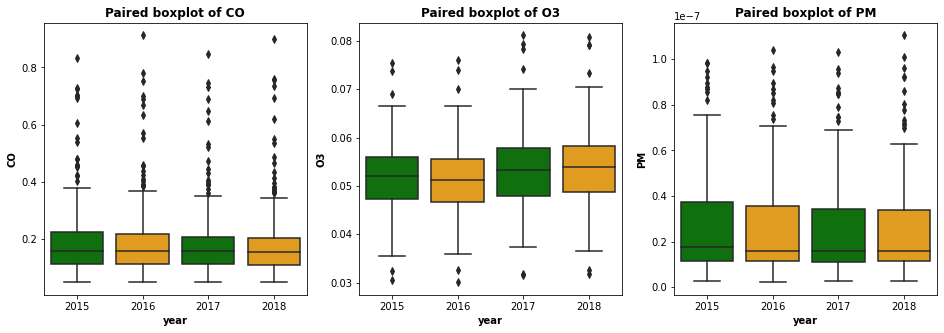

In [15]:
paired_boxplotting(numerical_features=['CO', 'O3', 'PM'], 
                   string=1, col=3, 
                   outcome='year',
                   df=df, 
                   figsize=(16, 5))

Можно сказать, что выбросы присутствую по каждому показтелю, хотя это только условно можно считать выбросами, это же раельные показатели в отдельных странах с высоким загрязнением и довольно любопытно как это коррелирует с другими показателями (здоровья, респираторной заболеваемостью, показателями счастья)

##### Duplicate and missing data

In [16]:
# посмотрим на пропуски в данных
dfs = {
    'CO_2015_2018': CO_2015_2018, 
    'O3_2015_2018': O3_2015_2018, 
    'PM_2015_2018': PM_2015_2018
}
for name, df in dfs.items():
  print(f' В {name} = {sum(df.isnull().sum())} пропусков')

 В CO_2015_2018 = 0 пропусков
 В O3_2015_2018 = 0 пропусков
 В PM_2015_2018 = 0 пропусков


In [17]:
# посмотрим на дубликаты в данных
for name, df in dfs.items():
  print(f' В {name} = {df.duplicated().sum()} дубликатов')

 В CO_2015_2018 = 0 дубликатов
 В O3_2015_2018 = 0 дубликатов
 В PM_2015_2018 = 0 дубликатов


##### Feature engeneering

In [18]:
# добавим столбец по среднему показателю за 4 года
CO_2015_2018['CO_mean'] = CO_2015_2018.groupby('country')['CO'].transform('mean')
O3_2015_2018['O3_mean'] = O3_2015_2018.groupby('country')['O3'].transform('mean')
PM_2015_2018['PM_mean'] = PM_2015_2018.groupby('country')['PM'].transform('mean')

In [19]:
# добавим столбец по изменению показателя за 4 года
CO_2015_2018['uplift_CO'] = CO_2015_2018.groupby('country')['CO'].diff()
O3_2015_2018['uplift_O3'] = O3_2015_2018.groupby('country')['O3'].diff()
PM_2015_2018['uplift_PM'] = PM_2015_2018.groupby('country')['PM'].diff()

In [20]:
# сделаем общую таблицу с показателями загрязнений за 2015-2018 года
df_2015_2018 = CO_2015_2018.merge(O3_2015_2018, on=['country', 'year'])
df_pollution_2015_2018 = df_2015_2018.merge(PM_2015_2018, on=['country', 'year'])
df_pollution_2015_2018.head()

,country,year,CO,CO_mean,uplift_CO,O3,O3_mean,uplift_O3,PM,PM_mean,uplift_PM
0,Afghanistan,2015,0.188489,0.189521,NaN,0.057616,0.058226,NaN,2.037780e-08,2.239198e-08,NaN
1,Afghanistan,2016,0.190931,0.189521,0.002441,0.057530,0.058226,-0.000087,2.067060e-08,2.239198e-08,2.928000e-10
2,Afghanistan,2017,0.195364,0.189521,0.004433,0.058393,0.058226,0.000864,2.057590e-08,2.239198e-08,-9.470000e-11
3,Afghanistan,2018,0.183300,0.189521,-0.012064,0.059366,0.058226,0.000973,2.794360e-08,2.239198e-08,7.367700e-09
4,Albania,2015,0.156164,0.146900,NaN,0.058433,0.059796,NaN,1.148180e-08,1.181145e-08,NaN


### Dataset: Mortality

In [21]:
!git clone https://github.com/EugeneBaev-dsu4/pawfull.git
respiratory = pd.read_csv('pawfull/respiratory-disease-death-rate.csv')

fatal: destination path 'pawfull' already exists and is not an empty directory.


In [22]:
respiratory.rename(
    columns = {
        'Deaths - Chronic respiratory diseases - Sex: Both - Age: Age-standardized (Rate)': 'mortality', 
        'Entity': "country",
        'Year': 'year'
    }, inplace = True
)
respiratory.head()

,country,Code,year,mortality
0,Afghanistan,AFG,1990,94.84
1,Afghanistan,AFG,1991,94.36
2,Afghanistan,AFG,1992,94.06
3,Afghanistan,AFG,1993,94.85
4,Afghanistan,AFG,1994,96.23


##### Converting to suitable data types

In [23]:
# оставляем нужные нам диапазон лет
respiratory = respiratory[
    (respiratory['year'] >= 2015) & (respiratory['year'] <= 2018)
].reset_index(drop=True)
respiratory.head()

,country,Code,year,mortality
0,Afghanistan,AFG,2015,72.11
1,Afghanistan,AFG,2016,70.90
2,Afghanistan,AFG,2017,69.95
3,Afghanistan,AFG,2018,68.95
4,African Region (WHO),NaN,2015,46.36


##### Duplicate and missing data

In [24]:
respiratory.duplicated().sum()

0

In [25]:
respiratory.isna().sum()

country       0
Code         92
year          0
mortality     0
dtype: int64

##### Feature engeneering

In [26]:
# Добавляем параметр - прирост летальности
respiratory['increase_mort'] = respiratory.groupby('country')['mortality'].diff()
respiratory.head()

,country,Code,year,mortality,increase_mort
0,Afghanistan,AFG,2015,72.11,NaN
1,Afghanistan,AFG,2016,70.90,-1.21
2,Afghanistan,AFG,2017,69.95,-0.95
3,Afghanistan,AFG,2018,68.95,-1.00
4,African Region (WHO),NaN,2015,46.36,NaN


### Dstaset: Smoking

In [27]:
!git clone https://github.com/ekaterinatao/datatone_Pawfull
smoking = pd.read_csv('datatone_Pawfull/data/share-of-adults-who-smoke.csv')
smoking.head()

fatal: destination path 'datatone_Pawfull' already exists and is not an empty directory.


,Entity,Code,Year,Prevalence of current tobacco use (% of adults)
0,Afghanistan,AFG,2000,36.900002
1,Afghanistan,AFG,2005,32.700001
2,Afghanistan,AFG,2010,29.100000
3,Afghanistan,AFG,2015,26.000000
4,Afghanistan,AFG,2018,23.799999


In [28]:
smoking.rename(
    columns = {
        'Prevalence of current tobacco use (% of adults)': 'smoke_prev', 
        'Entity': "country",
        'Year': 'year'
        }, inplace = True
)

##### Converting to suitable data types

In [29]:
# оставляем нужные нам диапазон лет
smoking = smoking[
    (smoking['year'] >= 2015) & (smoking['year'] <= 2018)
].reset_index(drop=True)
smoking.head()

,country,Code,year,smoke_prev
0,Afghanistan,AFG,2015,26.000000
1,Afghanistan,AFG,2018,23.799999
2,Albania,ALB,2015,25.100000
3,Albania,ALB,2018,23.000000
4,Algeria,DZA,2015,21.100000


##### Duplicate and missing data

In [30]:
smoking.duplicated().sum()

0

In [31]:
smoking.isna().sum()

country        0
Code          28
year           0
smoke_prev     0
dtype: int64

##### Feature engeneering

In [32]:
# Добавляем параметр - прирост куращих
smoking['increse_smoke'] = smoking.groupby('country')['smoke_prev'].diff()
smoking.head()

,country,Code,year,smoke_prev,increse_smoke
0,Afghanistan,AFG,2015,26.000000,NaN
1,Afghanistan,AFG,2018,23.799999,-2.200001
2,Albania,ALB,2015,25.100000,NaN
3,Albania,ALB,2018,23.000000,-2.100000
4,Algeria,DZA,2015,21.100000,NaN


### Dataset: Happiness

In [33]:
!git clone https://github.com/EugeneBaev-dsu4/pawfull.git
happiness = pd.concat(
    [pd.read_csv(i).assign(year= i) for i in glob.glob('pawfull/happiness_201[5678]*')], 
    axis=0
).reset_index(drop=True)
happiness['year'] = happiness['year'].apply(col_year).astype(int)
happiness.head()

fatal: destination path 'pawfull' already exists and is not an empty directory.


,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,...,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Perceptions of corruption,Lower Confidence Interval,Upper Confidence Interval
0,Norway,1.0,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Denmark,2.0,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Iceland,3.0,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Switzerland,4.0,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Finland,5.0,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
happiness.columns

Index(['Country', 'Happiness.Rank', 'Happiness.Score', 'Whisker.high',
       'Whisker.low', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.', 'Dystopia.Residual', 'year', 'Region',
       'Happiness Rank', 'Happiness Score', 'Standard Error',
       'Economy (GDP per Capita)', 'Health (Life Expectancy)',
       'Trust (Government Corruption)', 'Dystopia Residual', 'Overall rank',
       'Country or region', 'Score', 'GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices',
       'Perceptions of corruption', 'Lower Confidence Interval',
       'Upper Confidence Interval'],
      dtype='object')

In [35]:
# В сете колонки с одинаковыми по смыслу данными, но в колонках с разным  названием, соберем в одно целое...
happiness['Country'] = (
    happiness['Country'].combine_first(happiness['Country or region'])
)
happiness['Economy (GDP per Capita)'] = (
    happiness['Economy (GDP per Capita)']
    .combine_first(happiness['GDP per capita'])
)
happiness['Economy (GDP per Capita)'] = (
    happiness['Economy (GDP per Capita)']
    .combine_first(happiness['Economy..GDP.per.Capita.'])
)
happiness['Health (Life Expectancy)']= (
    happiness['Health (Life Expectancy)']
    .combine_first(happiness['Healthy life expectancy'])
)
happiness['Health (Life Expectancy)']= (
    happiness['Health (Life Expectancy)']
    .combine_first(happiness['Health..Life.Expectancy.'])
)
happiness['Trust (Government Corruption)'] = (
    happiness['Trust (Government Corruption)']
    .combine_first(happiness['Perceptions of corruption'])
)
happiness['Trust (Government Corruption)'] = (
    happiness['Trust (Government Corruption)']
    .combine_first(happiness['Trust..Government.Corruption.'])
)
happiness['Freedom'] = (
    happiness['Freedom'].combine_first(happiness['Freedom to make life choices'])
)
happiness['Happiness Rank'] = (
    happiness['Happiness Rank'].combine_first(happiness['Happiness.Rank'])
)
happiness['Happiness Score'] = (
    happiness['Happiness Score'].combine_first(happiness['Happiness.Score'])
)
happiness['Happiness Score'] = (
    happiness['Happiness Score'].combine_first(happiness['Score'])
)
happiness['Lower Confidence Interval'] = (
    happiness['Lower Confidence Interval'].combine_first(happiness['Whisker.low'])
)
happiness['Upper Confidence Interval'] = (
    happiness['Upper Confidence Interval'].combine_first(happiness['Whisker.high'])
)
happiness['Dystopia Residual'] = (
    happiness['Dystopia Residual'].combine_first(happiness['Dystopia.Residual'])
)

In [36]:
# уберем ставшими ненужными колонки
happiness = happiness.drop(
    columns=[
        'Country or region',
        'GDP per capita',
        'Economy..GDP.per.Capita.',
        'Healthy life expectancy',
        'Healthy life expectancy',
        'Health..Life.Expectancy.',
        'Perceptions of corruption',
        'Trust..Government.Corruption.',
        'Freedom to make life choices',
        'Happiness Rank',
        'Happiness.Rank',
        'Happiness.Score',
        'Whisker.low',
        'Whisker.high',
        'Dystopia.Residual',
        'Standard Error',
        'Overall rank',
        'Score',
        'Social support', 
        'Lower Confidence Interval', 
        'Upper Confidence Interval'
        ]
)

### Converting to suitable data types

In [37]:
# переводи в категоральный вид страны и регионы
happiness[['Country','Region']] = happiness[
    ['Country','Region']
].astype("category")
happiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Country                        626 non-null    category
 1   Family                         470 non-null    float64 
 2   Freedom                        626 non-null    float64 
 3   Generosity                     626 non-null    float64 
 4   year                           626 non-null    int64   
 5   Region                         315 non-null    category
 6   Happiness Score                626 non-null    float64 
 7   Economy (GDP per Capita)       626 non-null    float64 
 8   Health (Life Expectancy)       626 non-null    float64 
 9   Trust (Government Corruption)  625 non-null    float64 
 10  Dystopia Residual              470 non-null    float64 
dtypes: category(2), float64(8), int64(1)
memory usage: 51.7 KB


In [38]:
happiness.rename(columns = {'Country': 'country'}, inplace = True)

### Duplicate and missing data

In [39]:
happiness.isna().sum()

country                            0
Family                           156
Freedom                            0
Generosity                         0
year                               0
Region                           311
Happiness Score                    0
Economy (GDP per Capita)           0
Health (Life Expectancy)           0
Trust (Government Corruption)      1
Dystopia Residual                156
dtype: int64

In [40]:
happiness.duplicated().sum()

0

### Merging datasets

In [41]:
resp_smoke = respiratory.merge(smoking, how='left', on=['country', 'year'])
resp_smoke.head()

,country,Code_x,year,mortality,increase_mort,Code_y,smoke_prev,increse_smoke
0,Afghanistan,AFG,2015,72.11,NaN,AFG,26.000000,NaN
1,Afghanistan,AFG,2016,70.90,-1.21,NaN,NaN,NaN
2,Afghanistan,AFG,2017,69.95,-0.95,NaN,NaN,NaN
3,Afghanistan,AFG,2018,68.95,-1.00,AFG,23.799999,-2.200001
4,African Region (WHO),NaN,2015,46.36,NaN,NaN,NaN,NaN


In [42]:
resp_smoke_poll = resp_smoke.merge(
    df_pollution_2015_2018, how='left', on=['country', 'year']
)
resp_smoke_poll.head()

,country,Code_x,year,mortality,increase_mort,Code_y,smoke_prev,increse_smoke,CO,CO_mean,uplift_CO,O3,O3_mean,uplift_O3,PM,PM_mean,uplift_PM
0,Afghanistan,AFG,2015,72.11,NaN,AFG,26.000000,NaN,0.188489,0.189521,NaN,0.057616,0.058226,NaN,2.037780e-08,2.239198e-08,NaN
1,Afghanistan,AFG,2016,70.90,-1.21,NaN,NaN,NaN,0.190931,0.189521,0.002441,0.057530,0.058226,-0.000087,2.067060e-08,2.239198e-08,2.928000e-10
2,Afghanistan,AFG,2017,69.95,-0.95,NaN,NaN,NaN,0.195364,0.189521,0.004433,0.058393,0.058226,0.000864,2.057590e-08,2.239198e-08,-9.470000e-11
3,Afghanistan,AFG,2018,68.95,-1.00,AFG,23.799999,-2.200001,0.183300,0.189521,-0.012064,0.059366,0.058226,0.000973,2.794360e-08,2.239198e-08,7.367700e-09
4,African Region (WHO),NaN,2015,46.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Итоговый объединенный датасет
df_final = resp_smoke_poll.merge(happiness, how='left', on=['country', 'year'])
df_final.head()

,country,Code_x,year,mortality,increase_mort,Code_y,smoke_prev,increse_smoke,CO,CO_mean,...,uplift_PM,Family,Freedom,Generosity,Region,Happiness Score,Economy (GDP per Capita),Health (Life Expectancy),Trust (Government Corruption),Dystopia Residual
0,Afghanistan,AFG,2015,72.11,NaN,AFG,26.000000,NaN,0.188489,0.189521,...,NaN,0.302850,0.23414,0.365100,Southern Asia,3.575,0.319820,0.303350,0.097190,1.952100
1,Afghanistan,AFG,2016,70.90,-1.21,NaN,NaN,NaN,0.190931,0.189521,...,2.928000e-10,0.110370,0.16430,0.312680,Southern Asia,3.360,0.382270,0.173440,0.071120,2.145580
2,Afghanistan,AFG,2017,69.95,-0.95,NaN,NaN,NaN,0.195364,0.189521,...,-9.470000e-11,0.581543,0.10618,0.311871,NaN,3.794,0.401477,0.180747,0.061158,2.150801
3,Afghanistan,AFG,2018,68.95,-1.00,AFG,23.799999,-2.200001,0.183300,0.189521,...,7.367700e-09,NaN,0.08500,0.191000,NaN,3.632,0.332000,0.255000,0.036000,NaN
4,African Region (WHO),NaN,2015,46.36,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

### Descriptive statistics

In [44]:
# Скопируем датасет
df_fin_eda = df_final.copy()
df_fin_eda.head()

,country,Code_x,year,mortality,increase_mort,Code_y,smoke_prev,increse_smoke,CO,CO_mean,...,uplift_PM,Family,Freedom,Generosity,Region,Happiness Score,Economy (GDP per Capita),Health (Life Expectancy),Trust (Government Corruption),Dystopia Residual
0,Afghanistan,AFG,2015,72.11,NaN,AFG,26.000000,NaN,0.188489,0.189521,...,NaN,0.302850,0.23414,0.365100,Southern Asia,3.575,0.319820,0.303350,0.097190,1.952100
1,Afghanistan,AFG,2016,70.90,-1.21,NaN,NaN,NaN,0.190931,0.189521,...,2.928000e-10,0.110370,0.16430,0.312680,Southern Asia,3.360,0.382270,0.173440,0.071120,2.145580
2,Afghanistan,AFG,2017,69.95,-0.95,NaN,NaN,NaN,0.195364,0.189521,...,-9.470000e-11,0.581543,0.10618,0.311871,NaN,3.794,0.401477,0.180747,0.061158,2.150801
3,Afghanistan,AFG,2018,68.95,-1.00,AFG,23.799999,-2.200001,0.183300,0.189521,...,7.367700e-09,NaN,0.08500,0.191000,NaN,3.632,0.332000,0.255000,0.036000,NaN
4,African Region (WHO),NaN,2015,46.36,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# датасет сгруппированный по странам.
df_fin_eda_agg = df_fin_eda.groupby('country').mean()
df_fin_eda_agg.head()

,mortality,increase_mort,smoke_prev,increse_smoke,CO,CO_mean,uplift_CO,O3,O3_mean,uplift_O3,...,PM_mean,uplift_PM,Family,Freedom,Generosity,Happiness Score,Economy (GDP per Capita),Health (Life Expectancy),Trust (Government Corruption),Dystopia Residual
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,70.4775,-1.053333,24.90,-2.200001,0.189521,0.189521,-0.001730,0.058226,0.058226,0.000583,...,2.239198e-08,2.521933e-09,0.331588,0.147405,0.295163,3.59025,0.358892,0.228134,0.066367,2.082827
African Region (WHO),45.0925,-0.836667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,19.9200,-0.126667,24.05,-2.100000,0.146900,0.146900,-0.005617,0.059796,0.059796,0.000715,...,1.181145e-08,3.588333e-10,0.703218,0.369122,0.165358,4.71100,0.936541,0.766120,0.047251,1.772514
Algeria,31.2100,-0.410000,21.05,-0.100000,0.214400,0.214400,-0.002692,0.062517,0.062517,0.001407,...,3.083785e-08,2.308667e-10,1.019009,0.201546,0.068274,5.78175,1.015704,0.635071,0.154124,2.802911
American Samoa,58.4100,-0.386667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Выделим список численных переменных.
num_features = df_fin_eda_agg.columns

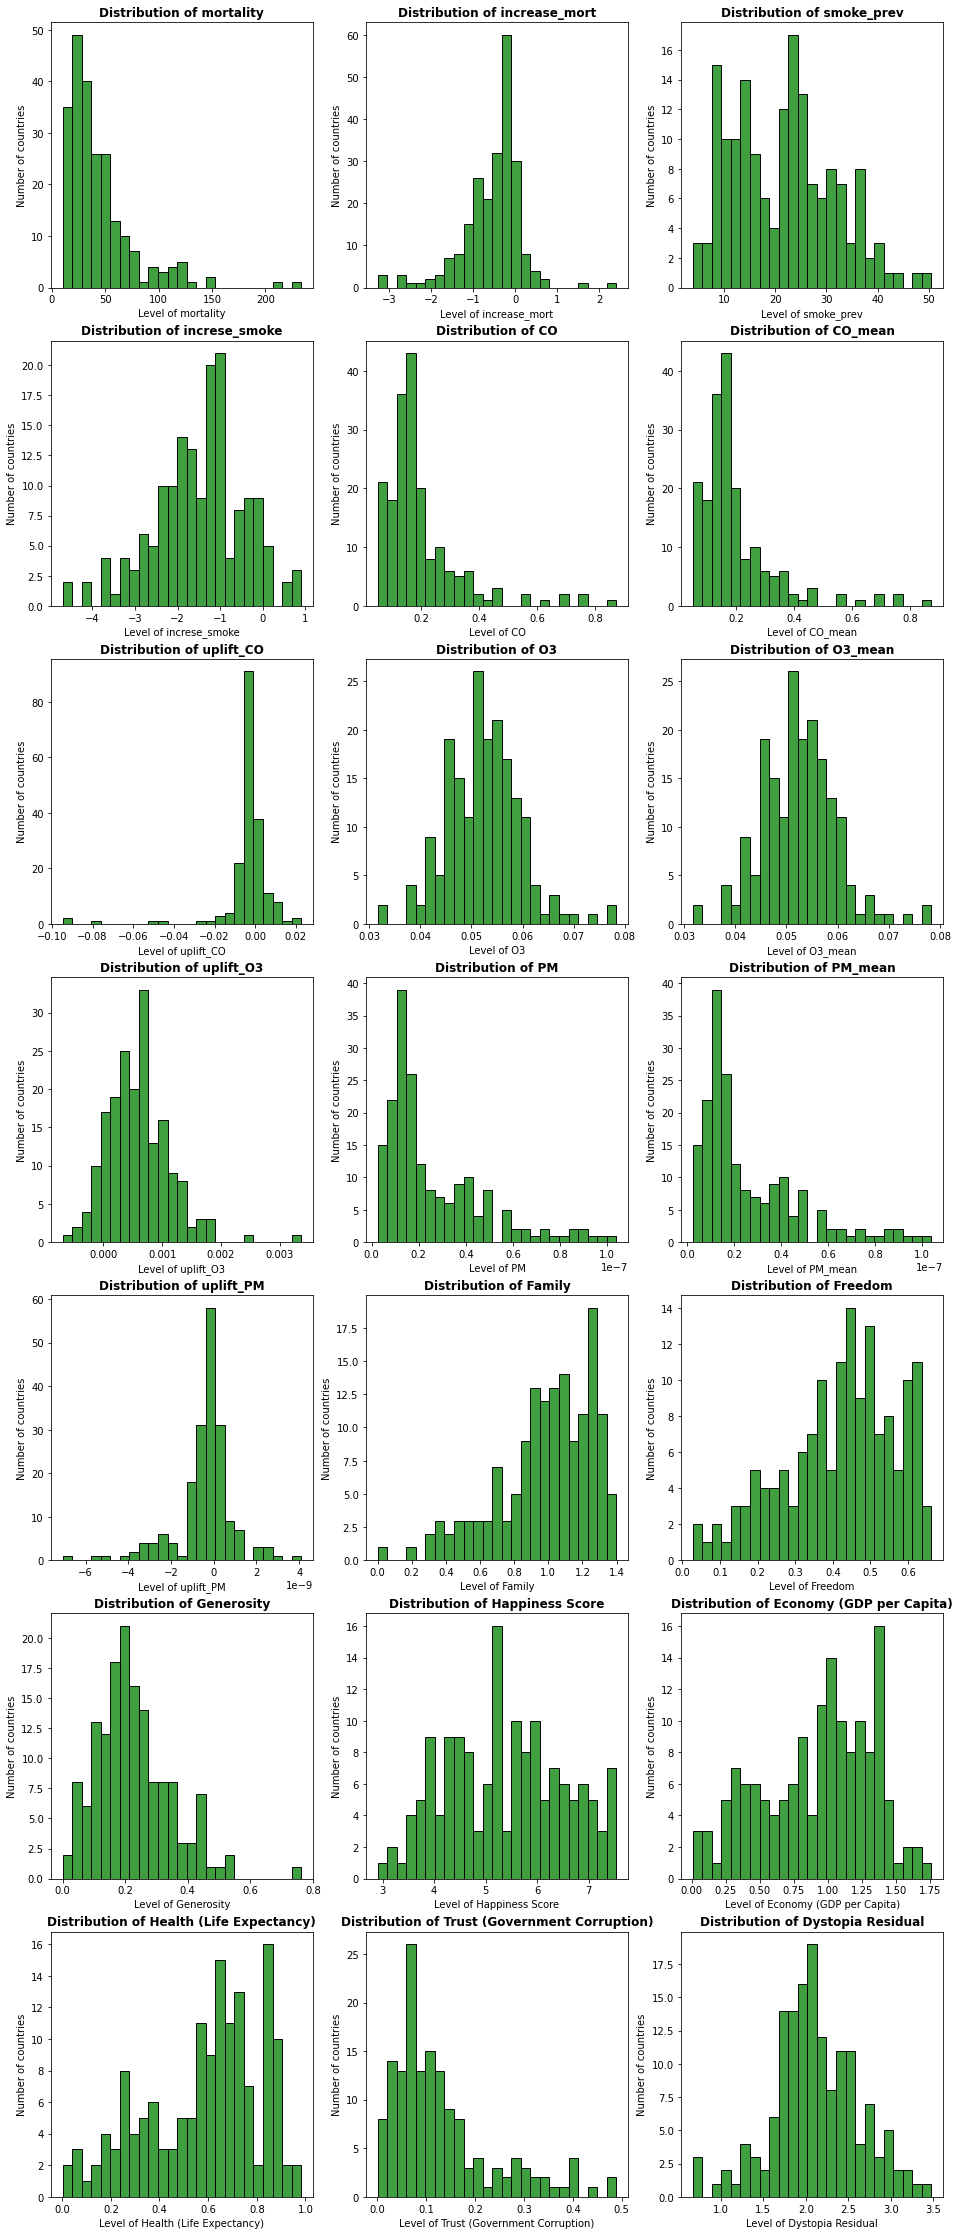

In [47]:
# Гистограммы численных стоблцов (данные сгруппированы по странам, занчения средние на все года).

histogramming(numerical_features=num_features, 
              string=7, col=3, df=df_fin_eda_agg, figsize=(16,40))

In [48]:
# Проверка на нормальность тестом Шапиро-Уилка.
    
for feature in num_features:
    shapiro_wilk(feature, df_fin_eda_agg)

mortality p-value = 4.398707938668341e-17
increase_mort p-value = 1.499730027665347e-11
smoke_prev p-value = 0.0028359745629131794
increse_smoke p-value = 0.102641262114048
CO p-value = 5.008149004485647e-16
CO_mean p-value = 5.008149004485647e-16
uplift_CO p-value = 3.3431354659059824e-22
O3 p-value = 0.014797809533774853
O3_mean p-value = 0.014797809533774853
uplift_O3 p-value = 4.917681962979259e-06
PM p-value = 9.718907536399035e-14
PM_mean p-value = 9.718907536399035e-14
uplift_PM p-value = 7.865104401094669e-12
Family p-value = 5.088480747872381e-07
Freedom p-value = 0.0002838537620846182
Generosity p-value = 3.596901296987198e-05
Happiness Score p-value = 0.013618689961731434
Economy (GDP per Capita) p-value = 0.001176348072476685
Health (Life Expectancy) p-value = 1.7435280824429356e-05
Trust (Government Corruption) p-value = 6.639986477319226e-11
Dystopia Residual p-value = 0.15677882730960846


Распределения increse_smoke, Dystopia Residual близки к нормальному, остальные отличаются.  
Mortality, CO, PM, Trust(Government Corruption) - визуально выглядят как лог-нормальное распределение.

In [49]:
# Датасет сгруппированный по годам по всем странам.

df_fin_eda_agg_year = df_fin_eda.groupby('year').mean()
df_fin_eda_agg_year.head()

,mortality,increase_mort,smoke_prev,increse_smoke,CO,CO_mean,uplift_CO,O3,O3_mean,uplift_O3,...,PM_mean,uplift_PM,Family,Freedom,Generosity,Happiness Score,Economy (GDP per Capita),Health (Life Expectancy),Trust (Government Corruption),Dystopia Residual
year,,,,,,,,,,,,,,,,,,,,,
2015,44.909035,NaN,22.224565,NaN,0.205369,0.199721,NaN,0.051737,0.052375,NaN,...,2.632703e-08,NaN,0.993545,0.431717,0.237078,5.403374,0.854105,0.637399,0.143457,2.106093
2016,44.294254,-0.614781,NaN,NaN,0.203032,0.199721,-0.002336,0.051258,0.052375,-0.00048,...,2.632703e-08,-9.900454e-10,0.796760,0.374039,0.242246,5.404224,0.961895,0.560452,0.137151,2.331680
2017,43.813947,-0.480307,NaN,NaN,0.196172,0.199721,-0.006860,0.052978,0.052375,0.00172,...,2.632703e-08,-3.773860e-10,1.189961,0.410949,0.248433,5.362621,0.984207,0.550687,0.124529,1.853818
2018,43.321009,-0.492939,20.720336,-1.504229,0.194309,0.199721,-0.001863,0.053528,0.052375,0.00055,...,2.632703e-08,8.026979e-11,NaN,0.454555,0.182260,5.379521,0.891973,0.598158,0.113648,NaN


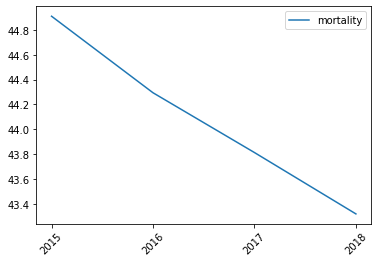

In [50]:
# Динамика уровня смертности по годам по всем странам.
years = df_fin_eda_agg_year.index.to_list()

plt.xticks(np.arange(2015, 2019), rotation=45)
plt.plot(years, df_fin_eda_agg_year['mortality'], label='mortality')
plt.legend();

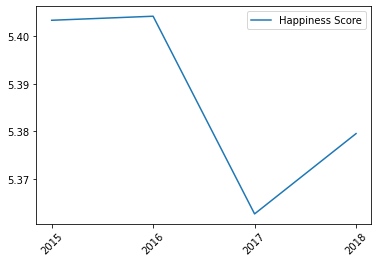

In [51]:
# Динамика уровня счастья по годам по всем странам.

plt.xticks(np.arange(2015, 2019), rotation=45)
plt.plot(years, df_fin_eda_agg_year['Happiness Score'], label='Happiness Score')
plt.legend();

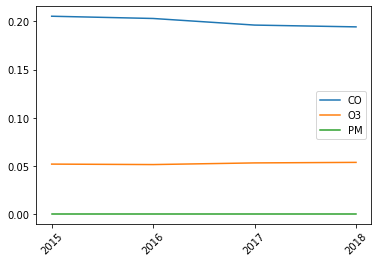

In [52]:
# Дианмика уровней загрязнения воздуха по годам по всем странам.

plt.xticks(np.arange(2015, 2019), rotation=45)
plt.plot(years, df_fin_eda_agg_year['CO'], label='CO')
plt.plot(years, df_fin_eda_agg_year['O3'], label='O3')
plt.plot(years, df_fin_eda_agg_year['PM'], label='PM')
plt.legend();

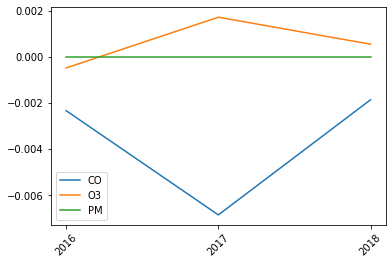

In [53]:
# Динамика изменений уровня зангрязния воздуха по годам по вссем странам.

plt.xticks(np.arange(2015, 2019), rotation=45)
plt.plot(years, df_fin_eda_agg_year['uplift_CO'], label='CO')
plt.plot(years, df_fin_eda_agg_year['uplift_O3'], label='O3')
plt.plot(years, df_fin_eda_agg_year['uplift_PM'], label='PM')
plt.legend();

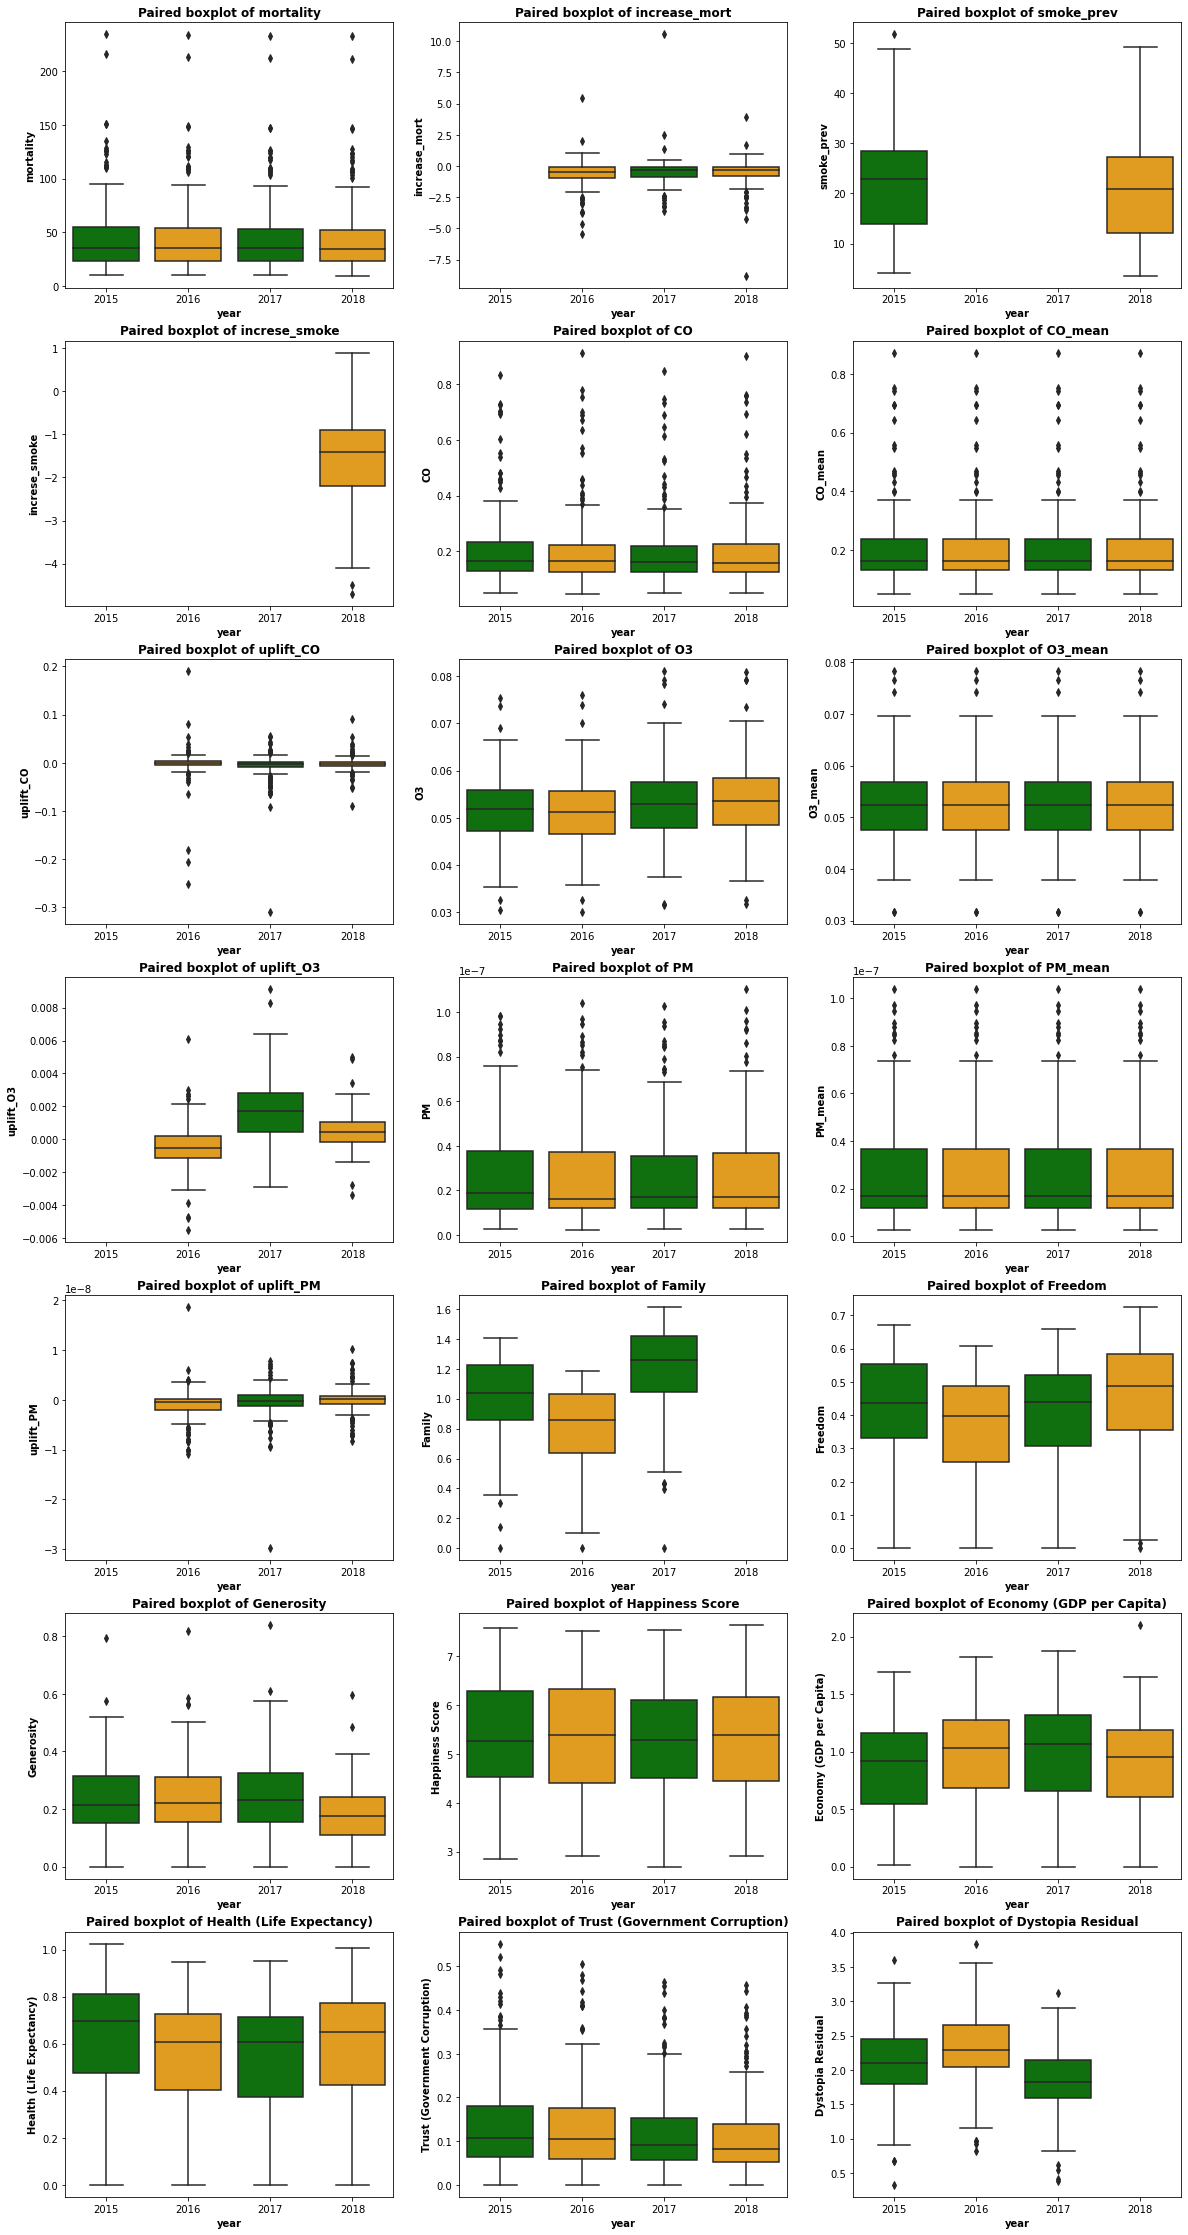

In [54]:
# Боксплоты численных признаков с разбивкой по годам.

paired_boxplotting(numerical_features=num_features, string=7,
                   col=3, df=df_fin_eda, figsize=(20,40), outcome='year')

### Check multicollinearity
Целевая переменная - mortality.  
С ней значимо отрицательно коррелируют: 
- Happines Score (-0.54), 
- Economy (-0.62), 
- Health (-0.63),
- increase_mort(-0.69), 
- Family (-0.52).  

Определяется положительная корреляция (>= 0.5) для:  
- СО - РМ,
- uplift_O3 - Economy, 
- Happines score - Family,
- Economy - Family, 
- Health-Family, 
- Freedom-Family,
- Freedom - Happines_score, 
- Economy - Happines_score,
- Economy - Health, 
- Happines_score - Health,
- Health - uplift_O3.  

Колонки на удаление: Freedom, uplift_O3, Family, Happines Score, PM.

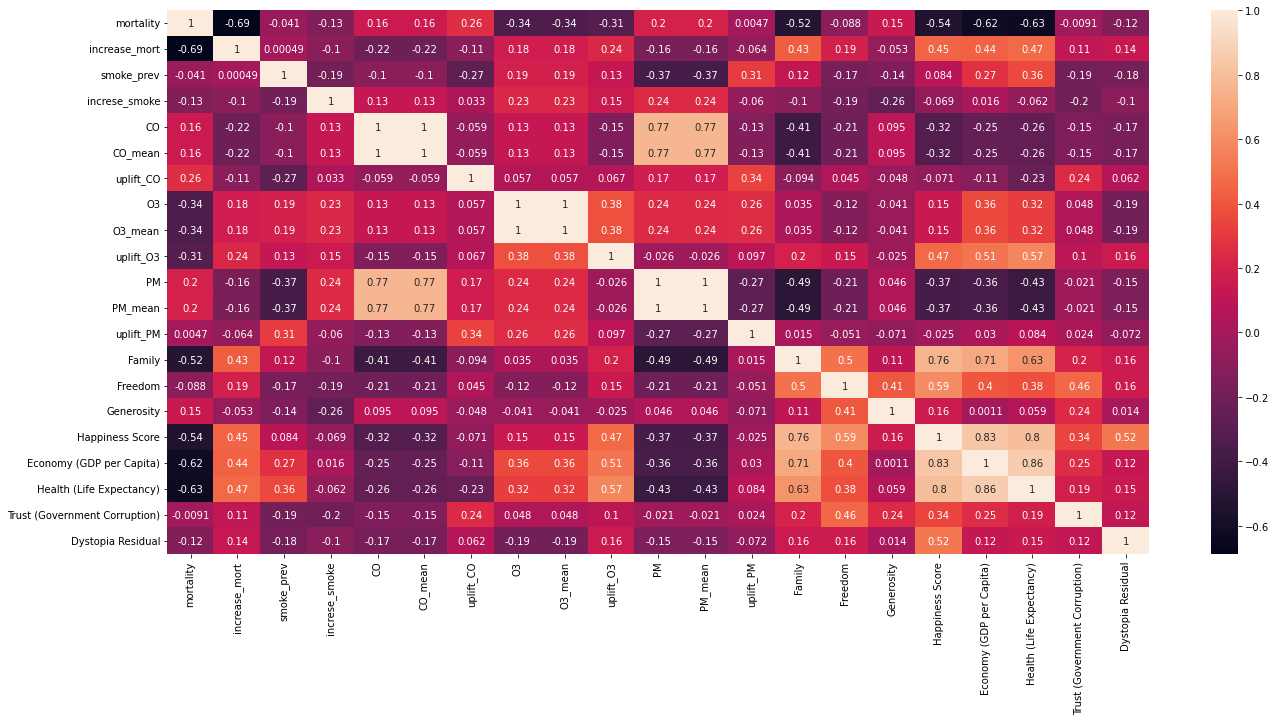

In [55]:
corr=df_fin_eda_agg.corr(method='spearman')

plt.figure(figsize=(22, 10))
sns.heatmap(corr, annot=True);

Text(0.5, 1.0, 'Correlation between mortality and increase mortality')

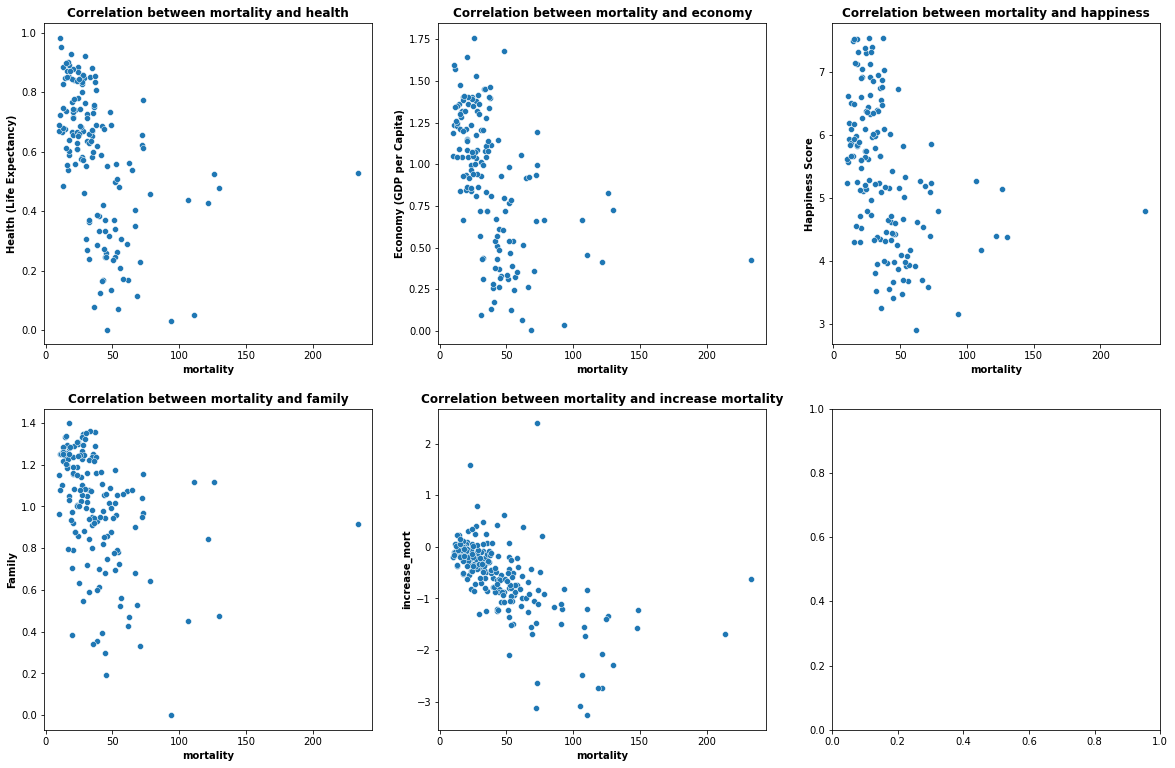

In [59]:
# Наиболее сильные корреляция на графиках

fig, axs = plt.subplots(2, 3, figsize=(20,13))
axs = axs.flatten()

sns.scatterplot(
    data=df_fin_eda_agg, x='mortality', y='Health (Life Expectancy)', ax=axs[0]
)
axs[0].set_xlabel('mortality', weight = 'bold')
axs[0].set_ylabel('Health (Life Expectancy)', weight='bold')
axs[0].set_title(
    'Correlation between mortality and health', fontsize=12, weight='bold'
)

sns.scatterplot(
    data=df_fin_eda_agg, x='mortality', y='Economy (GDP per Capita)', ax=axs[1]
)
axs[1].set_xlabel('mortality', weight = 'bold')
axs[1].set_ylabel('Economy (GDP per Capita)', weight='bold')
axs[1].set_title(
    'Correlation between mortality and economy', fontsize=12, weight='bold'
)

sns.scatterplot(
    data=df_fin_eda_agg, x='mortality', y='Happiness Score', ax=axs[2]
)
axs[2].set_xlabel('mortality', weight = 'bold')
axs[2].set_ylabel('Happiness Score', weight='bold')
axs[2].set_title(
    'Correlation between mortality and happiness', fontsize=12, weight='bold'
)

sns.scatterplot(data=df_fin_eda_agg, x='mortality', y='Family', ax=axs[3])
axs[3].set_xlabel('mortality', weight = 'bold')
axs[3].set_ylabel('Family', weight='bold')
axs[3].set_title(
    'Correlation between mortality and family', fontsize=12, weight='bold'
)

sns.scatterplot(data=df_fin_eda_agg, x='mortality', y='increase_mort', ax=axs[4])
axs[4].set_xlabel('mortality', weight = 'bold')
axs[4].set_ylabel('increase_mort', weight='bold')
axs[4].set_title(
    'Correlation between mortality and increase mortality', 
    fontsize=12, weight='bold'
)

### Подготовка данных к проверке статистических гипотез.

In [56]:
# Оценка процента пропущенных значений в изначальном датасете.
for col in df_fin_eda.columns:
    na = (df_fin_eda[col].isna().sum()/len(df_fin_eda[col]))*100
    print(f'{col}: percent_NaN = {round(na, 3)}%')

country: percent_NaN = 0.0%
Code_x: percent_NaN = 10.088%
year: percent_NaN = 0.0%
mortality: percent_NaN = 0.0%
increase_mort: percent_NaN = 25.0%
Code_y: percent_NaN = 64.035%
smoke_prev: percent_NaN = 64.035%
increse_smoke: percent_NaN = 82.018%
CO: percent_NaN = 17.982%
CO_mean: percent_NaN = 17.982%
uplift_CO: percent_NaN = 38.487%
O3: percent_NaN = 17.982%
O3_mean: percent_NaN = 17.982%
uplift_O3: percent_NaN = 38.487%
PM: percent_NaN = 17.982%
PM_mean: percent_NaN = 17.982%
uplift_PM: percent_NaN = 38.487%
Family: percent_NaN = 51.864%
Freedom: percent_NaN = 35.855%
Generosity: percent_NaN = 35.855%
Region: percent_NaN = 67.763%
Happiness Score: percent_NaN = 35.855%
Economy (GDP per Capita): percent_NaN = 35.855%
Health (Life Expectancy): percent_NaN = 35.855%
Trust (Government Corruption): percent_NaN = 35.965%
Dystopia Residual: percent_NaN = 51.864%


In [57]:
# Для датасета аггрегированного по странам.
for col in df_fin_eda_agg.columns:
    na = (df_fin_eda_agg[col].isna().sum()/len(df_fin_eda_agg[col]))*100
    print(f'{col}: percent_NaN = {round(na, 3)}%')

mortality: percent_NaN = 0.0%
increase_mort: percent_NaN = 0.0%
smoke_prev: percent_NaN = 28.07%
increse_smoke: percent_NaN = 28.07%
CO: percent_NaN = 17.982%
CO_mean: percent_NaN = 17.982%
uplift_CO: percent_NaN = 17.982%
O3: percent_NaN = 17.982%
O3_mean: percent_NaN = 17.982%
uplift_O3: percent_NaN = 17.982%
PM: percent_NaN = 17.982%
PM_mean: percent_NaN = 17.982%
uplift_PM: percent_NaN = 17.982%
Family: percent_NaN = 33.333%
Freedom: percent_NaN = 33.333%
Generosity: percent_NaN = 33.333%
Happiness Score: percent_NaN = 33.333%
Economy (GDP per Capita): percent_NaN = 33.333%
Health (Life Expectancy): percent_NaN = 33.333%
Trust (Government Corruption): percent_NaN = 33.333%
Dystopia Residual: percent_NaN = 33.333%


### Hypothesis testing
По результатам боксплотов можно проверить следующие гипотезы:  

Различается ли уровень экономики в странах с высокой и низкой смертностью.
(H0: уровень экономики значимо не отличается в обеих группах).  

Различается ли уровень счастья в странах с высокой и низкой смертностью.
(H0: уровень счастья значимо не отличается в обеих группах).  

Различается ли уровень СО в странах с высокой и низкой смертностью.
(H0: уровень СО значимо не отличается в обеих группах).  

Различается ли уровень О3 в странах с высокой и низкой смертностью.
(H0: уровень О3 значимо не отличается в обеих группах).  

Различается ли процент курильщиков в странах с высокой и низкой смертностью.
(H0: процент курильщиков значимо не отличается в обеих группах).

In [60]:
# Создадим колонку для разделения стран на категории (выше/ниже медианной смертности).

df_fin_eda_agg['high_mortality'] = (df_fin_eda_agg['mortality'] 
                                    > df_fin_eda_agg['mortality'].median())

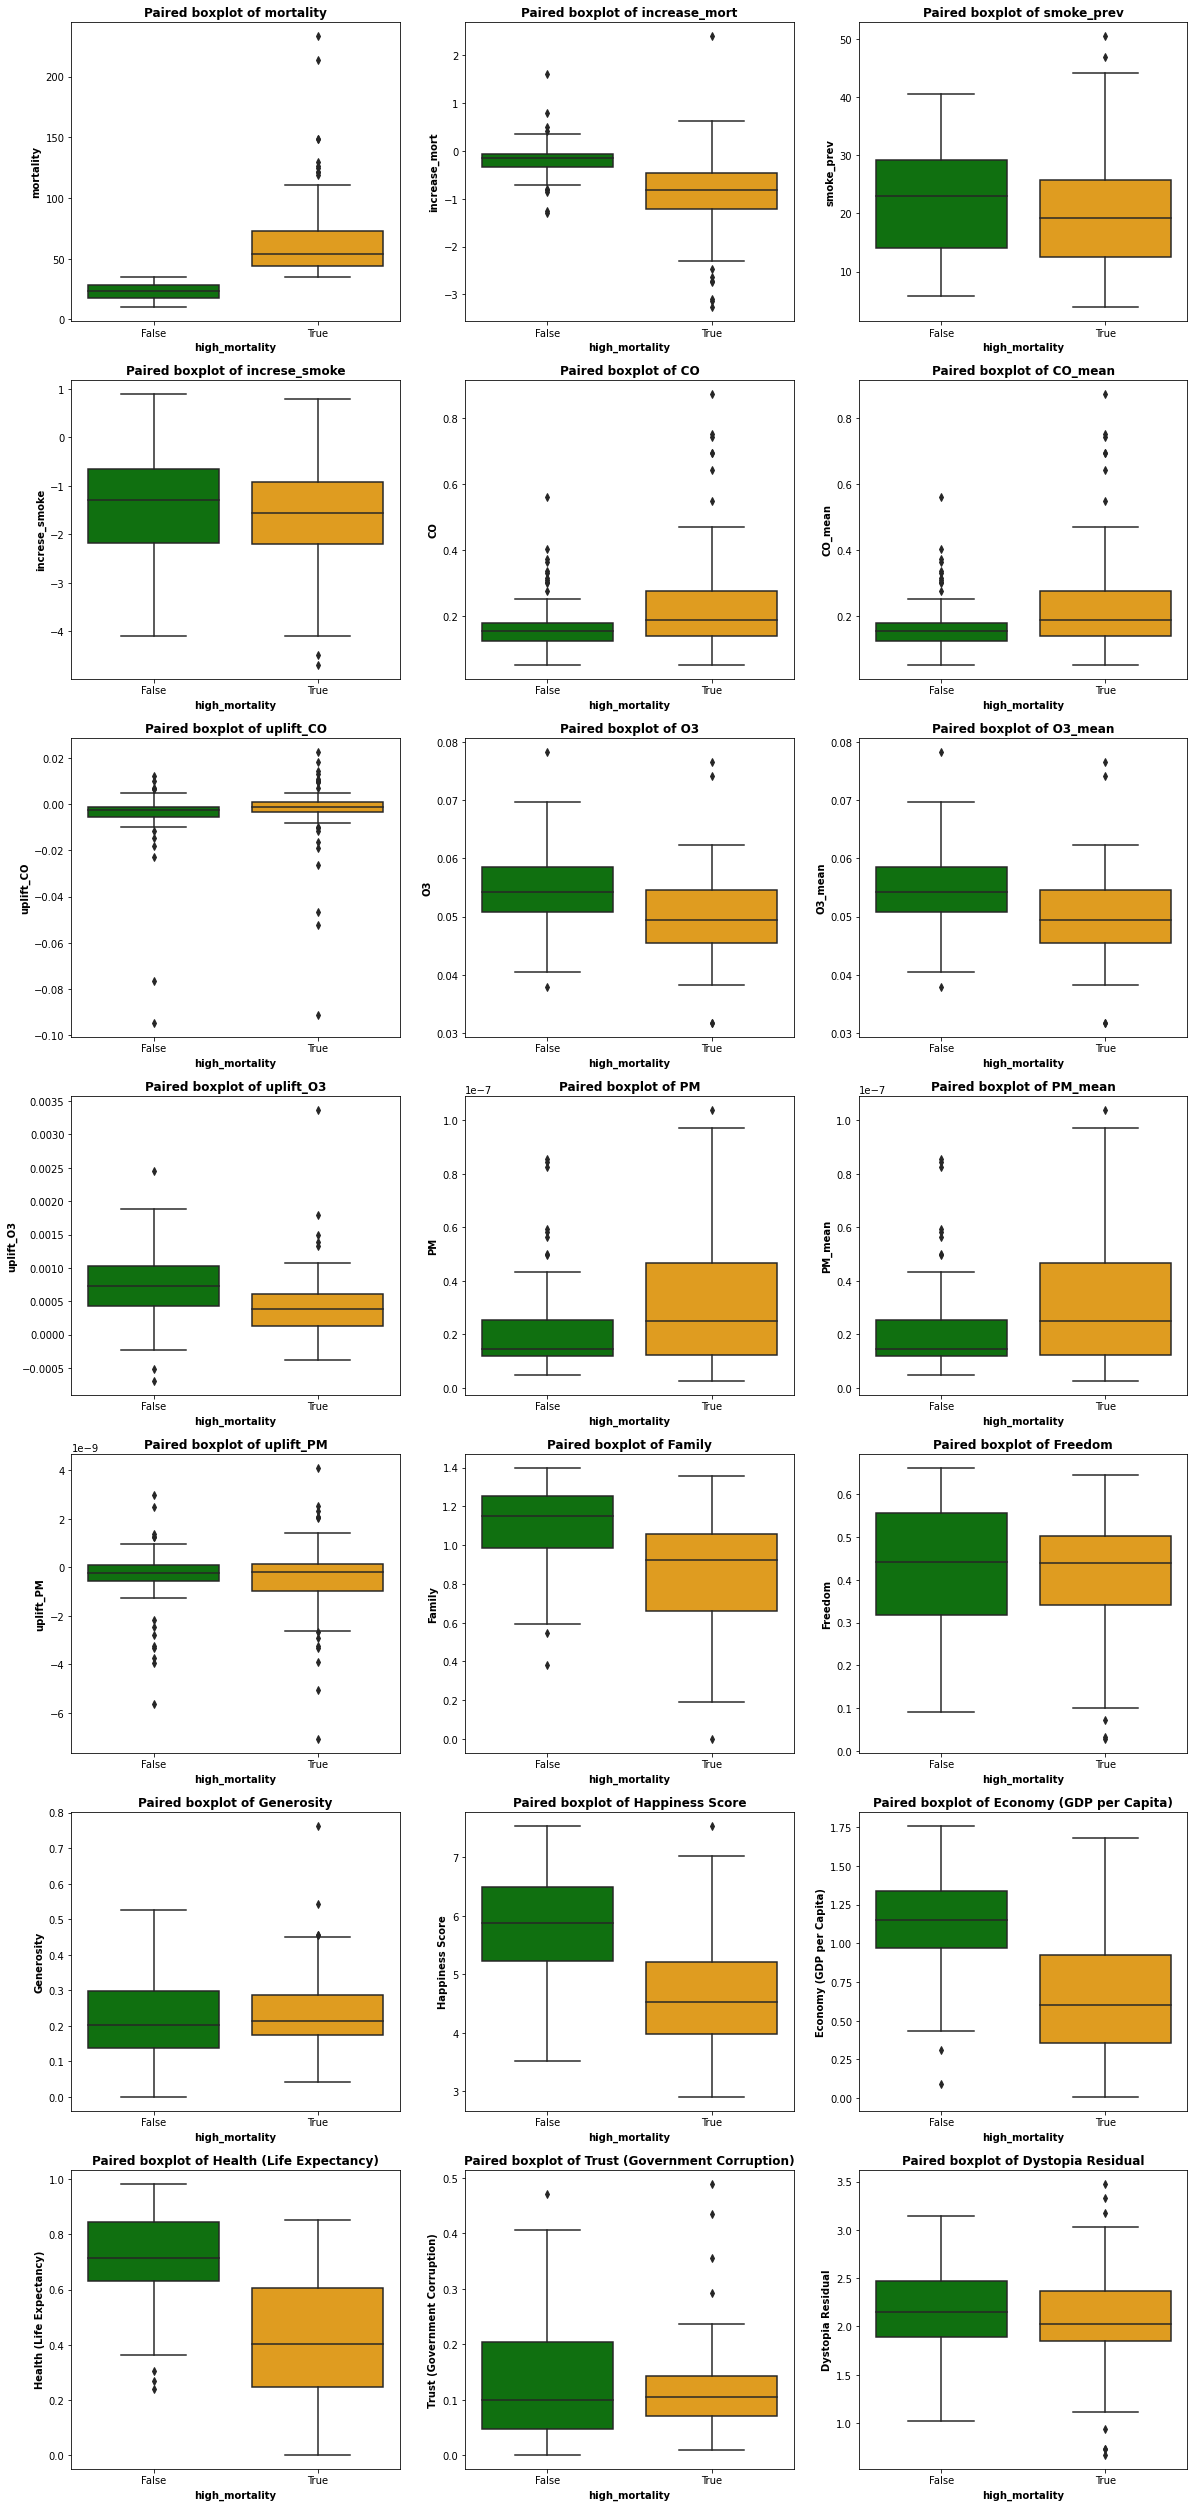

In [61]:
# Боксплоты для численных показателей для двух групп (высокая и низкая смертность).

paired_boxplotting(
    numerical_features=num_features, 
    string=7, col=3, 
    df=df_fin_eda_agg, 
    figsize=(20,45), 
    outcome='high_mortality'
)

In [63]:
cols_for_comp = [
    'Economy (GDP per Capita)', 'Happiness Score', 'CO', 'O3', 'smoke_prev'
]
       
for i in cols_for_comp:
    mannwhitneyu_test(
        df=df_fin_eda_agg, 
        feature=i, 
        outcome='high_mortality',
        number=len(cols_for_comp), 
        bonferroni=True
    )

Alpha after Bonferroni correction =  0.01
Different distributions of Economy (GDP per Capita) (reject H0), p=1.9759463312027344e-12
Alpha after Bonferroni correction =  0.01
Different distributions of Happiness Score (reject H0), p=5.47340314518327e-10
Alpha after Bonferroni correction =  0.01
Different distributions of CO (reject H0), p=0.0032832691144310837
Alpha after Bonferroni correction =  0.01
Different distributions of O3 (reject H0), p=7.766960346150911e-06
Alpha after Bonferroni correction =  0.01
Same distributions of smoke_prev(fail to reject H0), p=0.17127233889264637


В данном случае был выбрат тест Манна-Уитни, т.к. распределения отличаются от нормального, выборки являются независимыми.
По резульатам проверки (с учетом множественных попарных сравенений была применена поправка Бонферрони, с учетом поправки alpha=0.01).  
Была обнаружена статистически значимая разница по уровню экономики, счастья, уровню СО, уровню О3 в станах с высокой и низкой смертностью.

In [64]:
'''Исходя из высокого количества пропущенных значений и мультиколлинераности 
удаляются колонки: '''

df_fin_clean = df_fin_eda.drop([
    'Code_y', 'Code_x', 'uplift_PM', 'Region', 'Family', 'CO_mean', 'O3_mean',
     'Dystopia Residual', 'Freedom', 'Happiness Score', 'Health (Life Expectancy)',
     'PM', 'Generosity', 'Trust (Government Corruption)','PM_mean'
], axis=1)

In [65]:
#Убираем NaN из колонок (особое внимание к increse_smmoke)
df_fin_clean['increase_mort'] = df_fin_clean['increase_mort'].fillna(0)
df_fin_clean['uplift_CO'] = df_fin_clean['uplift_CO'].fillna(0)
df_fin_clean['uplift_O3'] = df_fin_clean['uplift_O3'].fillna(0)
df_fin_clean.loc[df_fin_clean['year'] == 2016, 'increse_smoke'] = 0
df_fin_clean.loc[df_fin_clean['year'] == 2017, 'increse_smoke'] = 0
#удаляем страны, по которым у нас нет данных
df_fin_clean = df_fin_clean.dropna(thresh=10, axis=0)

In [66]:
df_fin_clean.head()

,country,year,mortality,increase_mort,smoke_prev,increse_smoke,CO,uplift_CO,O3,uplift_O3,Economy (GDP per Capita)
0,Afghanistan,2015,72.11,0.00,26.000000,NaN,0.188489,0.000000,0.057616,0.000000,0.319820
1,Afghanistan,2016,70.90,-1.21,NaN,0.000000,0.190931,0.002441,0.057530,-0.000087,0.382270
2,Afghanistan,2017,69.95,-0.95,NaN,0.000000,0.195364,0.004433,0.058393,0.000864,0.401477
3,Afghanistan,2018,68.95,-1.00,23.799999,-2.200001,0.183300,-0.012064,0.059366,0.000973,0.332000
8,Albania,2015,20.09,0.00,25.100000,NaN,0.156164,0.000000,0.058433,0.000000,0.878670


In [67]:
# Количество пропущенных значений для общего очищенного датасета.

for col in df_fin_clean.columns:
    na = (df_fin_clean[col].isna().sum()/len(df_fin_clean[col]))*100
    print(f'{col}: percent_NaN = {round(na, 3)}%')

country: percent_NaN = 0.0%
year: percent_NaN = 0.0%
mortality: percent_NaN = 0.0%
increase_mort: percent_NaN = 0.0%
smoke_prev: percent_NaN = 50.439%
increse_smoke: percent_NaN = 22.496%
CO: percent_NaN = 0.0%
uplift_CO: percent_NaN = 0.0%
O3: percent_NaN = 0.0%
uplift_O3: percent_NaN = 0.0%
Economy (GDP per Capita): percent_NaN = 4.569%


In [68]:
# Объединяем по странам
df_clean_agg = df_fin_clean.groupby('country').mean()
df_clean_agg.head()

,mortality,increase_mort,smoke_prev,increse_smoke,CO,uplift_CO,O3,uplift_O3,Economy (GDP per Capita)
country,,,,,,,,,
Afghanistan,70.4775,-0.7900,24.90,-0.733334,0.189521,-0.001297,0.058226,0.000437,0.358892
Albania,19.9200,-0.0950,24.05,-0.700000,0.146900,-0.004213,0.059796,0.000536,0.936541
Algeria,31.2100,-0.3075,21.05,-0.033333,0.214400,-0.002019,0.062517,0.001055,1.015704
Andorra,25.8700,-0.1300,32.00,-1.000000,0.146828,-0.004895,0.054483,-0.000460,NaN
Angola,48.4650,-1.0050,NaN,0.000000,0.260055,-0.021510,0.048559,0.000198,0.852869


In [69]:
# Для очищенного датасета, аггрегированного по странам.

for col in df_clean_agg.columns:
    na = (df_clean_agg[col].isna().sum()/len(df_clean_agg[col]))*100
    print(f'{col}: percent_NaN = {round(na, 3)}%')

mortality: percent_NaN = 0.0%
increase_mort: percent_NaN = 0.0%
smoke_prev: percent_NaN = 10.465%
increse_smoke: percent_NaN = 0.0%
CO: percent_NaN = 0.0%
uplift_CO: percent_NaN = 0.0%
O3: percent_NaN = 0.0%
uplift_O3: percent_NaN = 0.0%
Economy (GDP per Capita): percent_NaN = 13.953%


### Попробуем заполнить пропуски при помощи импутации knn.

In [70]:
# Копируем датасет
df_without_na = df_clean_agg.copy()

# создаем объект класса Scaler
scaler = StandardScaler()

# масштабируем данные и сразу преобразуем их обратно в датафрейм
df_without_na = pd.DataFrame(
    scaler.fit_transform(df_without_na),
    columns = df_without_na.columns
)

# создадим объект этого класса с параметрами:
# пять соседей и однаковым весом каждого из них
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
df_without_na = pd.DataFrame(
    knn_imputer.fit_transform(df_without_na), 
    columns = df_without_na.columns
)

In [71]:
# Проверим все ли заполнилось.
df_without_na.isna().sum()

mortality                   0
increase_mort               0
smoke_prev                  0
increse_smoke               0
CO                          0
uplift_CO                   0
O3                          0
uplift_O3                   0
Economy (GDP per Capita)    0
dtype: int64

In [72]:
# Вернем исходный масштаб данным.
df_without_na = pd.DataFrame(
    scaler.inverse_transform(df_without_na), 
    columns = df_without_na.columns
)

# Вернем обратно страны индексом.
country = df_clean_agg.index.to_series()
df_without_na = df_without_na.set_index(country)

df_without_na.head()

,mortality,increase_mort,smoke_prev,increse_smoke,CO,uplift_CO,O3,uplift_O3,Economy (GDP per Capita)
country,,,,,,,,,
Afghanistan,70.4775,-0.7900,24.90,-0.733334,0.189521,-0.001297,0.058226,0.000437,0.358892
Albania,19.9200,-0.0950,24.05,-0.700000,0.146900,-0.004213,0.059796,0.000536,0.936541
Algeria,31.2100,-0.3075,21.05,-0.033333,0.214400,-0.002019,0.062517,0.001055,1.015704
Andorra,25.8700,-0.1300,32.00,-1.000000,0.146828,-0.004895,0.054483,-0.000460,1.121857
Angola,48.4650,-1.0050,22.97,0.000000,0.260055,-0.021510,0.048559,0.000198,0.852869


### Feature encoding

In [73]:
# Разделяем выборку на предикторы и целевую переменную
X = df_without_na.drop(columns = ['mortality'])
y = df_without_na['mortality']

# Делим выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

In [74]:
# Проводим стандартизацию предикторов
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model building
### XGBRegressor

In [75]:
# Выбор лучших параметров по сетке с кроссвалидацией на 10 блоках
model_xgb = xgb.XGBRegressor(verbosity = 0, silent=True)
param_xgb = {
    'n_estimators': [160, 100, 50],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.1, 0.01],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'tree_method': ['exact', 'approx', 'hist']
}
GS_xgb = GridSearchCV(
    estimator=model_xgb, 
    param_grid=param_xgb, 
    cv=10
).fit(X_train, y_train)
best_xgb = GS_xgb.best_estimator_
print('Лучшая модель: ', best_xgb)
print('Coefficient of determination: %.2f' %best_xgb.score(X_test, y_test))

Лучшая модель:  XGBRegressor(booster='dart', max_depth=2, silent=True, tree_method='exact',
             verbosity=0)
Coefficient of determination: 0.34


In [76]:
# Обучим модель
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model_xgb = xgb.XGBRegressor(
    booster='dart', tree_method='exact',
    n_estimators=360, max_depth=2,
    learning_rate=0.1, silent=True
)
model_xgb.fit(X_train, y_train)
rmse = -cross_val_score(
    model_xgb,
    X_test, y_test,
    cv=10, 
    scoring='neg_root_mean_squared_error'
)
print(f"RMSE = {np.mean(rmse)}")

RMSE = 30.622371046920364


### Регрессия Случайный лес

In [77]:
# Выбор лучших параметров по сетке с кроссвалидацией на 10 блоках
model_rf = RandomForestRegressor()
param_rf = {
    'n_estimators': [20, 10, 5],
    'max_depth': [20, 10, 50],
    'min_samples_leaf': [3, 5, 10],
    'max_features': [1, 0.8, 0.6],
    'bootstrap': [True, False]
}
GS_rf = GridSearchCV(
    estimator=model_rf, 
    param_grid=param_rf, 
    cv=10
).fit(X_train, y_train)
best_rf = GS_rf.best_estimator_
print('Лучшая модель: ', best_rf)
print('Coefficient of determination: %.2f' %best_rf.score(X_test, y_test))

Лучшая модель:  RandomForestRegressor(max_depth=20, max_features=0.8, min_samples_leaf=5,
                      n_estimators=20)
Coefficient of determination: 0.32


In [78]:
# Обучаем модель
model_rf = RandomForestRegressor(
    n_estimators=20, max_depth=20, 
    min_samples_leaf=5, max_features=0.8, 
    n_jobs=-1, bootstrap=True, random_state=0
)
model_rf.fit(X_train, y_train)
rmse = -cross_val_score(
    model_rf,
    X_test, y_test,
    cv=10,
    scoring='neg_root_mean_squared_error'
)
print(f"RMSE = {np.mean(rmse)}")

RMSE = 28.068391718277798


### Линейная регрессия

In [79]:
# Выбор лучших параметров по сетке с кроссвалидацией на 10 блоках
model_lr = LinearRegression()
param_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}
GS_lr = GridSearchCV(
    estimator=model_lr, 
    param_grid=param_lr, 
    cv=10
).fit(X_train, y_train)
best_lr = GS_lr.best_estimator_
print('Лучшая модель: ', best_lr)
print('Coefficient of determination: %.2f' %best_lr.score(X_test, y_test))


Лучшая модель:  LinearRegression()
Coefficient of determination: 0.41


In [81]:
# Обучаем модель
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
rmse = -cross_val_score(
    model_lr,
    X_test, y_test,
    cv=10,
    scoring='neg_root_mean_squared_error'
)
print(f"RMSE = {np.mean(rmse)}")

RMSE = 25.67092567679602


Во всех моделях качество не очень высокое. RMSE около 30 можно интерпретировать, как нашу ошибку в прогнозе уровня смертности равную 30 человек на 100 тыс. населения.  
Этот показатель не удовлетворителен, учитывая, что медиана смертности составляет 42 человек на 100 тыс. населения.  
Исходя из этого, мы решили применить смешивание моделей.  
### Ансамбль смешивания

In [82]:
# Смешаем дерево, линейную регрессию и XGBoost
stack_cv = KFold(n_splits=10, shuffle=True, random_state=0)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(
    model_lr, 
    X_train, y_train, 
    X_test, 
    stack_cv
)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(
    model_rf, 
    X_train, y_train, 
    X_test, 
    stack_cv
)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('XGB features...')
meta_tr, meta_te = get_meta_features(
    model_xgb, 
    X_train, y_train, 
    X_test, 
    stack_cv
)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('xgb_pred')

LR features...
RF features...
XGB features...


In [83]:
# Стэкинг мета-признаков с помощью LR
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

model_lr_meta = LinearRegression(n_jobs=-1)
model_lr_meta.fit(X_meta_train, y_train)

y_pred_meta_test = model_lr_meta.predict(X_meta_test)
rmse = -cross_val_score(
    model_lr,
    X_meta_test, y_pred_meta_test,
    cv=10,
    scoring='neg_root_mean_squared_error'
)
print(f"RMSE = {np.mean(rmse)}")

RMSE = 1.9249056071184826e-14


В результате использования ансамблей моделей улучшается качество предсказания. RMSE стремится к нулю. Однако такая низкая ошибка может свидетельствовать о переобучении модели. Оценка этого факта в цели настоящей работы не входила.  

Нашим следующим шагом была реализация алгоритма классификации по целевой переменной. Целевую переменную смертность мы разделили на 2 категории: выше и ниже медианы.  
### Random Forest classifier

In [84]:
# Делаем копию выборки и создаем бинарную переменную
df_rf = df_without_na.copy()
df_rf['high_mortality'] = (df_rf['mortality'] 
                           > df_rf['mortality'].median()).astype(int)

# Разделяем выборку на предикторы и целевую переменную
X = df_rf.drop(columns = ['mortality', 'high_mortality'])
y = df_rf['high_mortality']

# Проводим стандартизацию предикторов
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Делим выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=85
)

# **ПЕРЕД ЗАПУСКОМ ПРОЧТИ ЭТО**
Ячейку ниже запускать только на GPU (очень долго грузится ~40 минут)

In [85]:
# Выбор лучших параметров по сетке с кроссвалидацией на 10 блоках 
model_rc = RandomForestClassifier()
param_rc = {
    'n_estimators': [250, 200, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [30, 50, 70],
    'min_samples_leaf': [3, 5, 7],
    'min_samples_split': [2, 5, 8],
    'max_features': [1, 0.8, 0.6],
    'bootstrap': [True, False]
}
GS_rc = GridSearchCV(
    estimator=model_rc, 
    param_grid=param_rc, 
    cv=10
).fit(X_train, y_train)
best_rc = GS_rc.best_estimator_
print('Лучшая модель: ', best_rc)
print('Coefficient of determination: %.2f' %best_rc.score(X_test, y_test))

Лучшая модель:  RandomForestClassifier(criterion='entropy', max_depth=50, max_features=0.8,
                       min_samples_leaf=3, min_samples_split=5)
Coefficient of determination: 0.83


In [86]:
# Обучаем модель
clf = RandomForestClassifier(
    criterion='entropy', 
    max_depth=50, max_features=0.8,
    min_samples_leaf=3, min_samples_split=5,
    n_estimators=200
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [87]:
# Показатели качества.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90        29
           1       0.95      0.78      0.86        23

    accuracy                           0.88        52
   macro avg       0.90      0.87      0.88        52
weighted avg       0.89      0.88      0.88        52



Economy (GDP per Capita)    0.352717
increase_mort               0.335526
uplift_CO                   0.087781
smoke_prev                  0.054086
O3                          0.045029
CO                          0.043119
uplift_O3                   0.041842
increse_smoke               0.039900
dtype: float64


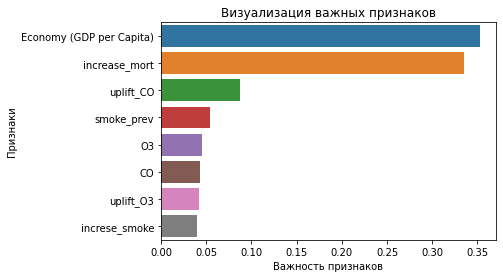

In [88]:
# Оценка важности признаков.
feature_imp = pd.Series(
    clf.feature_importances_, 
    index=X.columns
).sort_values(ascending=False)
print(feature_imp)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

In [89]:
# ROC AUC метрика
roc_value = roc_auc_score(y_test, y_pred)
print(f'ROC AUC = {round(roc_value, 3)}')

ROC AUC = 0.874


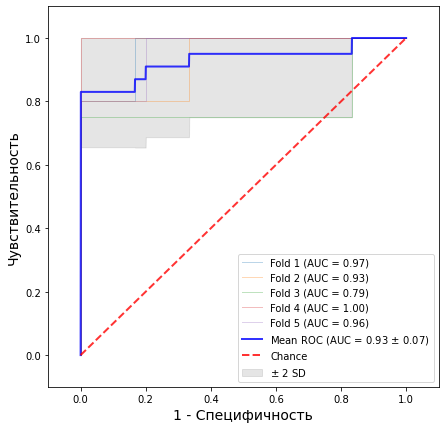

In [90]:
# Строим ROC кривую для полученной модели классификации
n_samples, n_features = X_test.shape

# Добавляем шум
random_state = np.random.RandomState(0)
x_1 = np.c_[X_test, random_state.randn(n_samples, 1 * n_features)]
# Расчет оптимальной кривой с валидацией на 5 блоках
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 1479)

# Строим ROC кривые
fig, ax = plt.subplots(figsize=(7,7))
for i, (train, test) in enumerate(cv.split(x_1, y_test)):
    clf.fit(x_1[train], y_test[train])
    viz = RocCurveDisplay.from_estimator(
        clf,
        x_1[test],
        y_test[test],
        name="Fold {}".format(i+1),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
# Строим среднюю кривую
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)
# Строим диагональ (0.5 шанс)
ax.plot(
    [0, 1], [0, 1], 
    linestyle="--", lw=2, color="r", 
    label="Chance", alpha=0.8
)
# Строим 95% доверительные интервалы
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 2 SD",
)

ax.set(
    xlim=[-0.1, 1.1],
    ylim=[-0.1, 1.1],
)
plt.xlabel("1 - Специфичность", fontdict={'fontsize': 14})
plt.ylabel("Чувствительность", fontdict={'fontsize': 14})
ax.legend(loc="lower right")
plt.show()